In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, expon, norm, probplot
from scipy.optimize import minimize

sns.set(style="whitegrid")

# Params
levels = 20
num_pegs = levels * (levels + 1) // 2

#Helper unctions

def angle_to_bias(theta):
    """Converts angle to bias"""
    return np.cos(theta / 2) ** 2


In [2]:
def build_galton_graph_parametrized(levels, angles, layers=1):
    """Constructs a Galton board graph with multi-layer QAOA-style parameters."""
    G = nx.DiGraph()
    node_id = lambda level, pos: f"{level}-{pos}"
    biases = angle_to_bias(np.array(angles).reshape(layers, -1))
    peg_index = 0

    for level in range(levels):
        for pos in range(level + 1):
            curr = node_id(level, pos)
            left = node_id(level + 1, pos)
            right = node_id(level + 1, pos + 1)

            layer = level % layers
            b = biases[layer, peg_index % biases.shape[1]] if peg_index < biases.shape[1] * layers else 0.5

            G.add_edge(curr, left, weight=1 - b)
            G.add_edge(curr, right, weight=b)
            peg_index += 1

    return G

In [3]:
def simulate_distribution(G, levels):
    start = "0-0"
    dist = {node: 0.0 for node in G.nodes()}
    dist[start] = 1.0
    for level in range(levels):
        next_dist = {node: 0.0 for node in G.nodes()}
        for node in dist:
            for succ in G.successors(node):
                next_dist[succ] += dist[node] * G[node][succ]['weight']
        dist = next_dist
    final_nodes = [n for n in dist if n.startswith(f"{levels}-")]
    probs = np.array([dist[n] for n in final_nodes])
    return probs / np.sum(probs)

In [4]:
def target_distribution(kind, size):
    if kind == "exponential":
        x_vals = np.linspace(0, 4, size)
        ref = expon.pdf(x_vals)
    elif kind == "normal":
        x_vals = np.linspace(-3, 3, size)
        ref = norm.pdf(x_vals)
    elif kind == "hadamard":
        ref = np.zeros(size)
        ref[size // 2] = 1.0
    else:
        raise ValueError("Unknown distribution type")
    return ref / np.sum(ref)

In [6]:
# statistical distance

from scipy.special import kl_div

def kl_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    return np.sum(kl_div(p, q))

In [7]:
def optimize_qaoa_params(levels, target_kind, layers=1):
    peg_count = levels * (levels + 1) // 2
    total_params = peg_count * layers
    init_angles = np.random.uniform(0, np.pi, size=total_params)

    def cost_fn(angles):
        G = build_galton_graph_parametrized(levels, angles, layers)
        probs = simulate_distribution(G, levels)
        target = target_distribution(target_kind, len(probs))
        return kl_divergence(probs, target)

    result = minimize(
        cost_fn,
        init_angles,
        method="COBYLA",
        options={"maxiter": 100}
    )

    G_final = build_galton_graph_parametrized(levels, result.x, layers)
    final_probs = simulate_distribution(G_final, levels)
    return final_probs, result.fun

In [8]:
# Compare 1-layer vs 2-layer QAOA across distributions
results = {}
for dist_kind in ["exponential", "normal", "hadamard"]:
    ref = target_distribution(dist_kind, levels + 1)

    probs_orig = simulate_distribution(
        build_galton_graph_parametrized(levels, [np.pi / 2] * num_pegs, layers=1),
        levels
    )
    kl_orig = kl_divergence(probs_orig, ref)

    probs_1_layer, kl_1 = optimize_qaoa_params(levels, dist_kind, layers=1)
    probs_2_layer, kl_2 = optimize_qaoa_params(levels, dist_kind, layers=2)

    results[dist_kind] = {
        "original": probs_orig,
        "qaoa_1": probs_1_layer,
        "qaoa_2": probs_2_layer,
        "reference": ref,
        "kl_orig": kl_orig,
        "kl_1": kl_1,
        "kl_2": kl_2
    }

c:\Users\13174\Documents\GaltonBoard\.pixi\envs\default\Lib\site-packages\scipy\_lib\pyprima\common\preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 212
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')
c:\Users\13174\Documents\GaltonBoard\.pixi\envs\default\Lib\site-packages\scipy\_lib\pyprima\common\preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 422
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


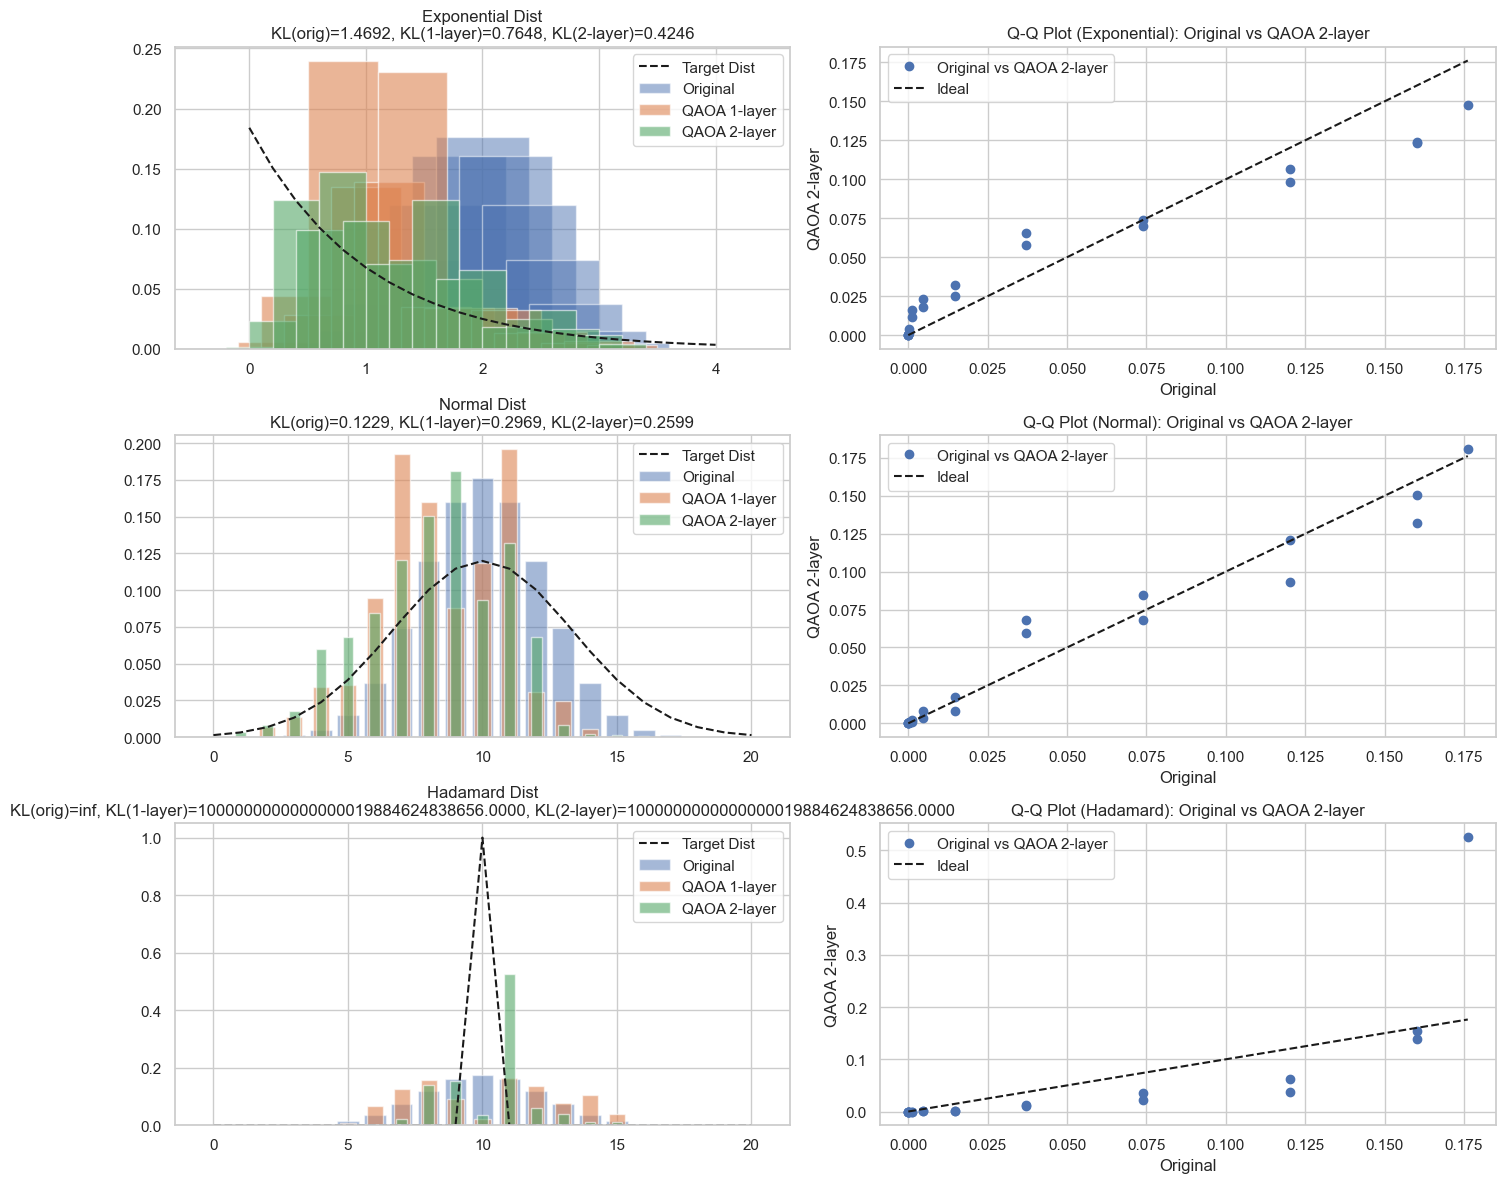

In [9]:
def qq_plot_custom(ax, p1, p2, label1="Original", label2="QAOA 2-layer"):
    """Plot quantiles of p1 vs p2 on a given axis."""
    # Normalize to get valid probability distributions
    p1 = np.asarray(p1) / np.sum(p1)
    p2 = np.asarray(p2) / np.sum(p2)

    q = np.linspace(0, 1, len(p1))
    quant1 = np.quantile(p1, q)
    quant2 = np.quantile(p2, q)

    ax.plot(quant1, quant2, 'o', label=f"{label1} vs {label2}")
    ax.plot(quant1, quant1, 'k--', label="Ideal")
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.grid(True)
    ax.legend()

# Main plotting loop
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
for i, dist_kind in enumerate(["exponential", "normal", "hadamard"]):
    r = results[dist_kind]
    x_vals = np.linspace(0, 4, len(r["reference"])) if dist_kind == "exponential" else np.arange(len(r["reference"]))

    # Bar Plot
    axs[i, 0].bar(x_vals, r["original"], width=0.8, alpha=0.5, label="Original")
    axs[i, 0].bar(x_vals, r["qaoa_1"], width=0.6, alpha=0.6, label="QAOA 1-layer")
    axs[i, 0].bar(x_vals, r["qaoa_2"], width=0.4, alpha=0.6, label="QAOA 2-layer")
    axs[i, 0].plot(x_vals, r["reference"], 'k--', label="Target Dist")
    axs[i, 0].legend()
    axs[i, 0].set_title(
        f"{dist_kind.capitalize()} Dist\n"
        f"KL(orig)={r['kl_orig']:.4f}, "
        f"KL(1-layer)={r['kl_1']:.4f}, "
        f"KL(2-layer)={r['kl_2']:.4f}"
    )

    # Q-Q Plot: 2-layer QAOA vs Original
    qq_plot_custom(axs[i, 1], r["original"], r["qaoa_2"])
    axs[i, 1].set_title(f"Q-Q Plot ({dist_kind.capitalize()}): Original vs QAOA 2-layer")

plt.tight_layout()
plt.show()